In [1]:
%matplotlib notebook

In [2]:
from pyroteus import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18

In [4]:
PETSc.Sys.popErrorHandler()

In [5]:
p = 1
family = "CG"
resolutions = [8, 16, 32, 64, 128, 256]
powers = [0, 1, 2, 3, 4]
targets = 100*4**np.array(powers)

In [6]:
def kernel(V):
    x, y = SpatialCoordinate(V.mesh())
    return x*y*(x-1)*(y-1)

In [7]:
sp = {
    "ksp_type": "cg",
    "pc_type": "none",
}
sp_mass_inv = {
    "mat_type": "matfree",
    "ksp_type": "preonly",
    "pc_type": "python",
    "pc_python_type": "firedrake.MassInvPC",
}
sp_ibp = {
    "ksp_type": "gmres",
    "ksp_gmres_restart": 20,
    "ksp_rtol": 1.0e-05,
    "pc_type": "sor",
}

In [8]:
def solve_forward(V, solver_parameters=sp):
    mesh = V.mesh()
    u, v = TrialFunction(V), TestFunction(V)
    x, y = SpatialCoordinate(V.mesh())
    f = 2*pi*pi*sin(pi*x)*sin(pi*y)
    
    a = inner(grad(u), grad(v))*dx
    L = f*v*dx
    
    uh = Function(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=solver_parameters)
    return uh

In [9]:
def solve_adjoint(V):
    mesh = V.mesh()
    u, v = TrialFunction(V), TestFunction(V)
    f = kernel(V)
    
    a = inner(grad(u), grad(v))*dx
    L = inner(grad(f), grad(v))*dx
    
    uh = Function(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    solve(a == L, uh, bcs=bc, solver_parameters=sp)
    return uh

In [10]:
def exact_solution(V):
    x, y = SpatialCoordinate(V.mesh())
    return sin(pi*x)*sin(pi*y)

In [11]:
def qoi(u, V=None):
    V = V or u.function_space()
    return assemble(inner(grad(u), grad(kernel(V)))*dx(domain=V.mesh()))

In [12]:
qoi_exact = 32/pi**4

In [13]:
dofs = []
elements = []
uniform = []
print("DoFs    QoI error")
for N in resolutions:
    mesh = UnitSquareMesh(N, N)
    Vc = FunctionSpace(mesh, family, p)
    uc = solve_forward(Vc)
    
    dof = Vc.dof_count
    Ju = qoi(uc, Vc)
    Je = abs(qoi_exact - Ju)/qoi_exact
    
    print(f"{dof:6d}  {Je:.4e}")
    dofs.append(dof)
    uniform.append(Je)

DoFs    QoI error
    81  3.7932e-02
   289  9.5992e-03
  1089  2.4071e-03
  4225  6.0224e-04
 16641  1.5059e-04
 66049  3.7649e-05


<IPython.core.display.Javascript object>


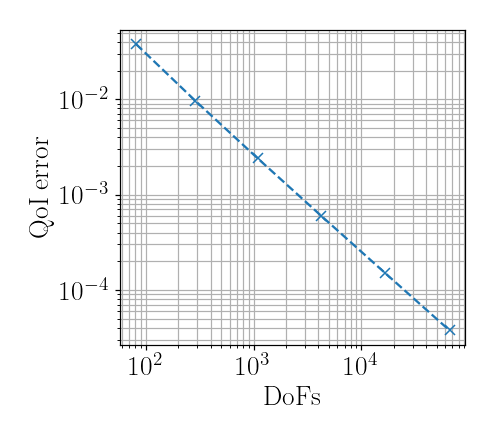

In [14]:
fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, uniform, '--x')
axes.set_xlabel("DoFs")
axes.set_ylabel("QoI error")
axes.grid(True, which='both')
plt.tight_layout()

In [15]:
def indicate_GEp(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    Vf = FunctionSpace(mesh, family, p+1)
    uf = solve_forward(Vf)
    P0 = FunctionSpace(mesh, "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mesh)
    loc = -p0test*dot(grad(kernel(Vc) - uc_adj), n)*(uf - uc)
    i_GEp = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, i_GEp, solver_parameters=sp_mass_inv)
    i_GEp += assemble(p0test*div(grad(kernel(Vc) - uc_adj))*(uf - uc)*dx)
    return i_GEp

In [16]:
def indicate_GEh(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    x, y = SpatialCoordinate(mesh)
    Vf = FunctionSpace(mh[1], family, p)
    uf = solve_forward(Vf)
    uc_prolong = Function(Vf)
    uc_adj_prolong = Function(Vf)
    prolong(uc, uc_prolong)
    prolong(uc_adj, uc_adj_prolong)
    x_prolong = Function(Vf)
    y_prolong = Function(Vf)
    prolong(interpolate(x, Vc), x_prolong)
    prolong(interpolate(y, Vc), y_prolong)
    k_prolong = x_prolong*(x_prolong-1)*y_prolong*(y_prolong-1)
    P0 = FunctionSpace(mh[1], "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mh[1])
    loc = -p0test*dot(grad(k_prolong - uc_adj_prolong), n)*(uf - uc_prolong)
    _i_GEh = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, _i_GEh, solver_parameters=sp_mass_inv)
    _i_GEh += assemble(p0test*div(grad(k_prolong - uc_adj_prolong))*(uf - uc_prolong)*dx)
    i_GEh = Function(FunctionSpace(mesh, "DG", 0))
    i_GEh.project(_i_GEh)
    i_GEh *= 4  # Four times fewer cells
    return i_GEh

In [17]:
def indicate_DQ(uc, uc_adj):
    Vc = uc.function_space()
    mesh = Vc.mesh()
    P0 = FunctionSpace(mesh, "DG", 0)
    p0test = TestFunction(P0)
    n = FacetNormal(mesh)
    loc = p0test*dot(grad(kernel(Vc) - uc_adj), n)*dot(grad(kernel(Vc) - uc_adj), n)
    flux = Function(P0)
    solve(TrialFunction(P0)*p0test*dx == (loc('+') + loc('-'))*dS + loc*ds, flux, solver_parameters=sp_mass_inv)
    cell = assemble(p0test*div(grad(kernel(Vc) - uc_adj))*div(grad(kernel(Vc) - uc_adj))*dx)
    vP1 = VectorFunctionSpace(mesh, "CG", 1)
    g, psi = TrialFunction(vP1), TestFunction(vP1)
    a = inner(g, psi)*dx
    L = uc*dot(psi, n)*ds - uc*div(psi)*dx
    g = Function(vP1)
    solve(a == L, g, solver_parameters=sp_ibp)
    h = CellSize(mesh)
    return interpolate(h**2*(sqrt(abs(cell)) + sqrt(abs(flux)/h))*sqrt(div(g)*div(g)), P0)

In [18]:
GEh, GEp, DQ = [], [], []
dofs_GEh, dofs_GEp, dofs_DQ = [], [], []
print("Target   GEp         GEh        DQ")
N = 10
maxiter = 4
to_plot = []
for j, target in enumerate(targets):
    
    # GE_p
    mesh_GEp = UnitSquareMesh(N, N)
    Je_old = None
    for i in range(maxiter):
        V = FunctionSpace(mesh_GEp, family, p)
        u = solve_forward(V)
        Je = qoi(u, V)
        if i == maxiter-1:
            break
        u_adj = solve_adjoint(V)
        M = isotropic_metric(indicate_GEp(u, u_adj))
        space_normalise(M, target, 1)
        mesh_GEp = adapt(mesh_GEp, M)
    GEp.append(abs(qoi_exact - Je)/qoi_exact)
    dofs_GEp.append(V.dof_count)
    
    # GE_h
    mesh_GEh = UnitSquareMesh(N, N)
    for i in range(maxiter):
        mh = MeshHierarchy(mesh_GEh, 1)
        V = FunctionSpace(mesh_GEh, family, p)
        u = solve_forward(V)
        Je = qoi(u, V)
        if i == maxiter-1:
            break
        u_adj = solve_adjoint(V)
        M = isotropic_metric(indicate_GEh(u, u_adj))
        space_normalise(M, target, 1)
        mesh_GEh = adapt(mesh_GEh, M)
    GEh.append(abs(qoi_exact - Je)/qoi_exact)
    dofs_GEh.append(V.dof_count)
    
    # DQ
    mesh_DQ = UnitSquareMesh(N, N)
    for i in range(maxiter):
        V = FunctionSpace(mesh_DQ, family, p)
        u = solve_forward(V)
        Je = qoi(u, V)
        if i == maxiter-1:
            break
        u_adj = solve_adjoint(V)
        M = isotropic_metric(indicate_DQ(u, u_adj))
        space_normalise(M, target, 1)
        mesh_DQ = adapt(mesh_DQ, M)
    DQ.append(abs(qoi_exact - Je)/qoi_exact)
    dofs_DQ.append(V.dof_count)
    
    print(f"{target:6.0f}   {GEp[-1]:.4e}  {GEh[-1]:.4e}  {DQ[-1]:.4e}")
    if j == 2:
        to_plot = [mesh_GEp, mesh_GEh, mesh_DQ]

Target       GEp          GEh          DQ
   100   1.3784e-02  1.2987e-02  1.5953e-02
   400   3.1879e-03  3.3545e-03  3.6914e-03
  1600   8.1078e-04  8.2183e-04  9.1033e-04
  6400   2.0466e-04  2.0260e-04  2.4121e-04
 25600   5.1745e-05  5.2262e-05  6.0617e-05


<IPython.core.display.Javascript object>


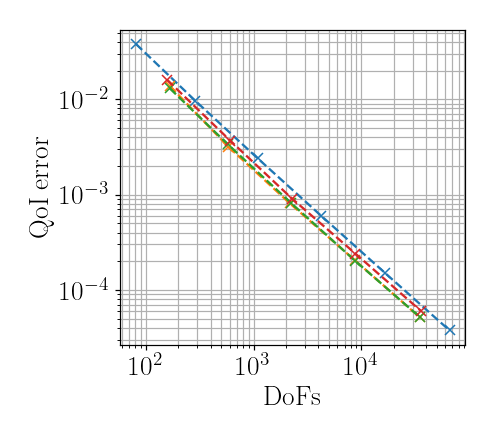

<IPython.core.display.Javascript object>


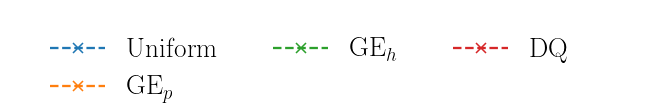

In [21]:
fig, axes = plt.subplots(figsize=(4.5, 4))
axes.loglog(dofs, uniform, '--x', label='Uniform')
axes.semilogx(dofs_GEp, GEp, '--x', label=r'GE$_p$')
axes.semilogx(dofs_GEh, GEh, '--x', label=r'GE$_h$')
axes.semilogx(dofs_DQ, DQ, '--x', label='DQ')
axes.set_xlabel("DoFs")
axes.set_ylabel("QoI error")
axes.grid(True, which='both')
plt.tight_layout()
plt.savefig('qoi_convergence.pdf')

fig2, axes2 = plt.subplots(figsize=(6, 1))
lines, labels = axes.get_legend_handles_labels()
legend = axes2.legend(lines, labels, fontsize=18, frameon=False, ncol=3)
fig2.canvas.draw()
axes2.set_axis_off()
bbox = legend.get_window_extent().transformed(fig2.dpi_scale_trans.inverted())
plt.savefig('legend_conv.pdf')

<IPython.core.display.Javascript object>


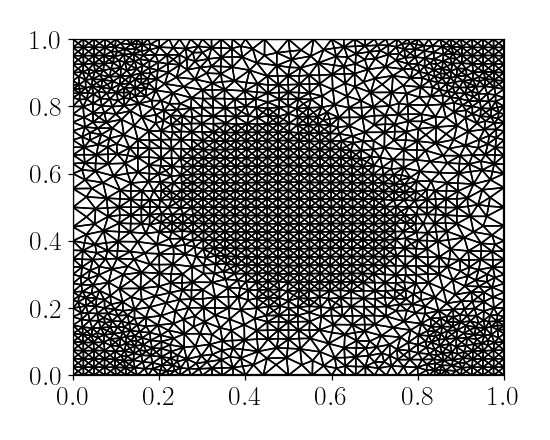

<IPython.core.display.Javascript object>


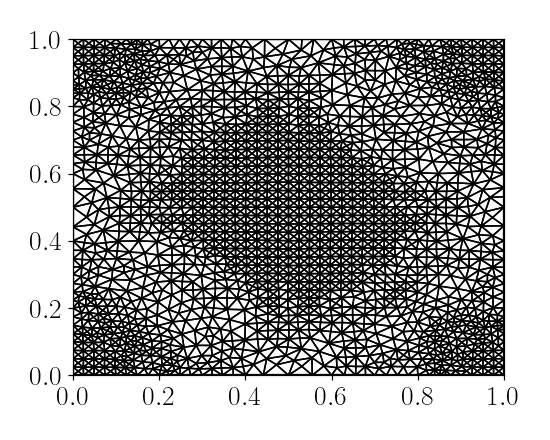

<IPython.core.display.Javascript object>


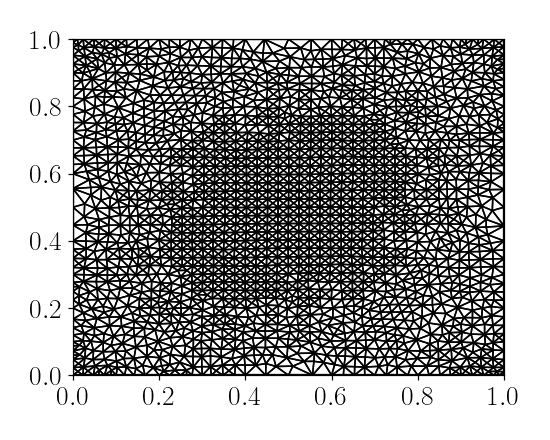

In [20]:
fig, axes = plt.subplots(figsize=(5, 4))
triplot(to_plot[0], axes=axes, boundary_kw={'edgecolor': 'k'})
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('mesh_GEp.jpg')

fig, axes = plt.subplots(figsize=(5, 4))
triplot(to_plot[1], axes=axes, boundary_kw={'edgecolor': 'k'})
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('mesh_GEh.jpg')

fig, axes = plt.subplots(figsize=(5, 4))
triplot(to_plot[2], axes=axes, boundary_kw={'edgecolor': 'k'})
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
plt.tight_layout()
plt.savefig('mesh_DQ.jpg')